<font color=blue>OVERVIEW</font>

In this project I'll be analyzing data from surveys on New York City High School students. NOTE: Large, bolded comments indicate code provided by DataQuest.

# Read in the data

In [45]:
#Read in data files
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [46]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [47]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [48]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [49]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [50]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [51]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [52]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [53]:
correlations = combined.corr()
correlations = correlations["sat_score"]
correlations

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [54]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

*From here forward is my code*

<font color = blue>INSTRUCTIONS</font>

- Set up matplotlib to work in Jupyter notebook.
- There are several fields in combined that originally came from a survey of parents, teachers, and students. Make a bar plot of the correlations between these fields and sat_score.
- You can find a list of the fields in the survey_fields variable in the notebook.
- Consult the data dictionary that's part of the zip file you can download from the City of New York's website.
- Did you find any surprising correlations?
- Write up your results in a Markdown cell.

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)

In [56]:
correlations.to_frame()

,sat_score
SAT Critical Reading Avg. Score,0.986820
SAT Math Avg. Score,0.972643
SAT Writing Avg. Score,0.987771
sat_score,1.000000
AP Test Takers,0.523140
Total Exams Taken,0.514333
Number of Exams with scores 3 4 or 5,0.463245
Total Cohort,0.325144
CSD,0.042948
NUMBER OF STUDENTS / SEATS FILLED,0.394626


In [57]:
survey_bar_data = correlations.loc[[ 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]]

In [58]:
survey_bar_data= survey_bar_data.loc["rr_s":"aca_tot_11"]
survey_bar_data.to_frame()
survey_bar_data.reset_index()

,index,sat_score
0,rr_s,0.232199
1,rr_t,-0.023386
2,rr_p,0.047925
3,N_s,0.423463
4,N_t,0.291463
5,N_p,0.421530
6,saf_p_11,0.122913
7,com_p_11,-0.115073
8,eng_p_11,0.020254
9,aca_p_11,0.035155


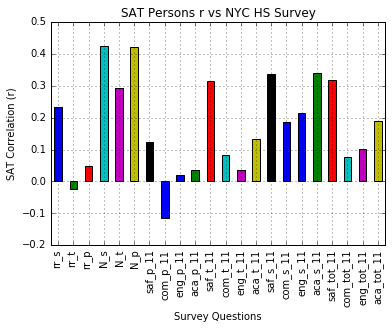

In [59]:
ax = survey_bar_data.plot(kind = 'bar', 
                     title = "SAT Persons r vs NYC HS Survey",
                         grid = True)
ax.set_xlabel("Survey Questions")
ax.set_ylabel("SAT Correlation (r)")
plt.show()

<font color = 'green'>COMMENTS</font>

- N_s: Number of student respondents
- N_t: Number of teacher respondents
- N_p: Number of parent respondents
- saf_t_11: Safety and Respect score based on teacher responses	
- saf_s_11: Safety and Respect score based on student responses
- aca_s_11: Academic expectations score based on student responses
- saf_tot_11: Safety and Respect total score

These correleation coefficients are small.  I question the teaching in Dataquest that r > 0.25 suggests a correlation exists.  However, it looks like safety,respect and number of respondents from the three response groups, plus the academic expectations of students may correlate in a meaningful way with SAT score.

These possible correlations make sense:  number of respondents is an indication of adademic motivation, academic expectations is a motivation indicator, and safety is an indicator of a productive learning environment.

<font color = 'blue'>INSTRUCTIONS</font>
- Investigate safety scores.
    - Make a scatter plot of the saf_s_11 column vs. the sat_score in combined.
    - Write up your conclusions about safety and SAT scores in a Markdown cell.
- Map out safety scores.
    - Compute the average safety score for each district.
    - Make a map that shows safety scores by district.
- Write up your conclusions about safety by geographic area in a Markdown cell. You may want to read up on the boroughs of New York City.

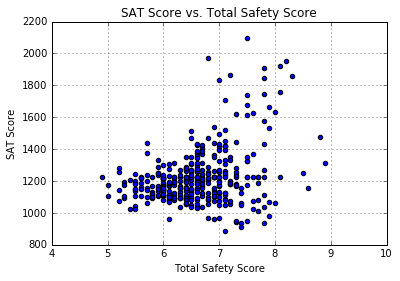

In [60]:
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

ax1.scatter(combined['saf_s_11'], combined["sat_score"])
ax1.set_title("SAT Score vs. Total Safety Score") 
ax1.set_xlabel("Total Safety Score")
ax1.set_ylabel("SAT Score")
ax1.grid(which='major', axis='both')

plt.show()

CONCLUSION

There is no correlation between safety and SAT score. There no change in SAT score when Total Safety Score is between 5 and less than 7.  For Total Safety Score 7-9 SAT score has a wide range.

In [61]:
combined.columns

Index(['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score', 'sat_score', 'SchoolName', 'AP Test Takers ',
       'Total Exams Taken',
       ...
       'priority05', 'priority06', 'priority07', 'priority08', 'priority09',
       'priority10', 'Location 1', 'lat', 'lon', 'school_dist'],
      dtype='object', length=160)

In [62]:
#Agg by district, calc mean safety, reset index, rename column
dist_agg = combined.groupby("school_dist").agg("mean")
dist_agg.rename(columns = {"saf_s_11":"Safety_Score"}, inplace = True)
dist_agg.tail()

,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO,schoolyear,fl_percent,frl_percent,total_enrollment,ell_num,ell_percent,sped_num,sped_percent,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_11,aca_t_11,Safety_Score,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
school_dist,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
28,445.941655,465.997286,435.908005,1347.846947,182.010490,273.559441,175.336364,351.214076,28.0,255.381164,8.719058,26.770807,21.349816,30.172038,0.0,20112012.0,0.0,53.790909,1210.636364,87.363636,4.963636,123.454545,9.827273,403.727273,31.345455,343.727273,37.509091,283.454545,19.954545,165.636364,9.400000,590.363636,45.863636,620.272727,54.136364,85.090909,85.545455,40.545455,872.545455,54.727273,362.636364,8.172727,7.590909,7.472727,7.781818,7.60,7.145455,7.363636,7.972727,6.627273,6.081818,6.618182,7.454545,7.463636,6.936364,7.145455,7.745455,12.0,12.0,11422.000000,1304.272727,2.545455,0.0,0.0,0.0,40.709344,-73.806367
29,395.764925,399.457090,386.707836,1181.929851,63.385817,96.514423,135.268750,98.108871,29.0,88.372155,3.454193,25.355632,21.409201,28.672730,0.0,20112012.0,0.0,52.362500,428.250000,12.625000,2.912500,56.125000,13.037500,20.750000,4.825000,359.875000,83.987500,39.000000,9.150000,4.125000,1.050000,219.875000,51.862500,208.375000,48.137500,77.625000,90.625000,44.750000,294.500000,21.375000,146.500000,7.762500,7.362500,7.325000,7.562500,7.05,6.912500,7.162500,7.575000,6.075000,5.962500,6.487500,7.250000,6.962500,6.737500,7.000000,7.475000,12.0,12.0,11413.625000,474.125000,1.250000,0.0,0.0,0.0,40.685276,-73.752740
30,430.679934,465.961857,429.740299,1326.382090,157.231838,252.123932,115.150000,310.526882,30.0,251.803744,9.260486,25.715644,19.312273,29.760726,0.0,20112012.0,0.0,54.211111,1221.555556,220.555556,16.133333,125.111111,7.988889,281.777778,24.866667,124.222222,10.444444,607.222222,43.522222,204.444444,20.788889,604.111111,44.777778,617.444444,55.222222,89.000000,85.444444,42.333333,963.444444,63.111111,318.777778,8.222222,7.444444,7.433333,7.700000,7.50,6.655556,6.911111,7.533333,7.033333,6.166667,6.844444,7.511111,7.577778,6.744444,7.077778,7.588889,12.0,12.0,11103.000000,1123.333333,2.555556,0.0,0.0,0.0,40.755398,-73.932306
31,457.500000,472.500000,452.500000,1382.500000,228.908654,355.111538,194.435000,450.787097,31.0,380.528319,13.251284,28.119729,19.995494,32.785641,0.0,20112012.0,0.0,38.310000,1850.600000,64.200000,2.860000,301.500000,16.710000,177.700000,10.300000,307.300000,18.270000,418.700000,22.170000,938.700000,48.810000,948.500000,52.090000,902.100000,47.910000,88.900000,91.300000,43.500000,1476.600000,88.900000,593.300000,7.800000,7.390000,7.460000,7.620000,7.21,7.140000,7.390000,7.860000,6.530000,6.070000,6.780000,7.330000,7.200000,6.870000,7.200000,7.610000,12.0,12.0,10307.100000,1847.500000,5.000000,0.0,0.0,0.0,40.595680,-74.125726
32,371.500000,385.833333,362.166667,1119.500000,70.342949,100.179487,83.558333,105.333333,32.0,100.525613,4.450572,22.479804,17.936520,26.816013,0.0,20112012.0,0.0,82.866667,420.833333,79.500000,18.533333,67.500000,15.650000,6.333333,1.750000,82.000000,19.833333,326.166667,76.850000,3.833333,0.966667,217.833333,51.716667,203.000000,48.283333,75.666667,72.333333,34.666667,312.833333,22.333333,137.833333,8.350000,8.050000,7.883333,8.216667,7.05,6.166667,6.900000,7.483333,6.766667,6.033333,6.783333,7.483333,7.383333,6.750000,7.200000,7.733333,12.0,12.0,11231.666667,3

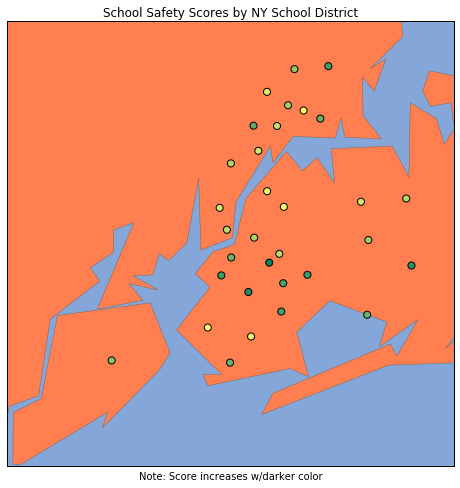

In [63]:
# map dist safety scores

fig= plt.figure(figsize = (8,8))

from mpl_toolkits.basemap import Basemap  #map of New York City
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color = "coral", lake_color = "aqua")

longitudes = dist_agg['lon'].tolist()
latitudes = dist_agg['lat'].tolist()

m.scatter(longitudes,latitudes, s = 50, zorder = 2, latlon = True, 
          cmap = 'summer', c = dist_agg['Safety_Score']) #c- shading kwarg

plt.title("School Safety Scores by NY School District")
plt.xlabel("Note: Score increases w/darker color")
plt.show()

<font color = 'red'>CONCLUSION</font>

No relationship between district location and safety score

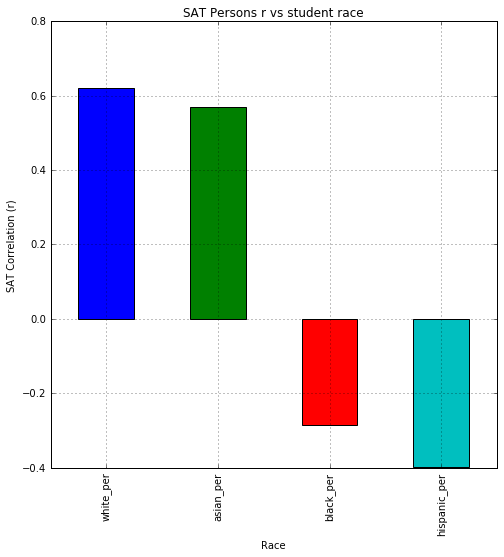

In [64]:
#Any racial differences correlated to SAT score? 
#repeat survey bar chart snippet

race_sat_data = correlations.loc[[ 
    "white_per",
    "asian_per",
    "black_per",
    "hispanic_per"
]]
race_sat_data.to_frame()
race_sat_data.reset_index()

fig = plt.figure(figsize = (8,8))
ax_race = fig.add_subplot(1,1,1)
ax_race = race_sat_data.plot(kind = 'bar', 
                     title = "SAT Persons r vs student race",
                         grid = True)
ax_race.set_xlabel("Race")
ax_race.set_ylabel("SAT Correlation (r)")
plt.show()

<font color = 'red'>CONCLUSION</font>

Even though the correlation coefficients aren't "close" to 1, this suggests a possible relationship between SAT scores and race. Again, for me these correlations aren't that strong and there may be no difference across races.

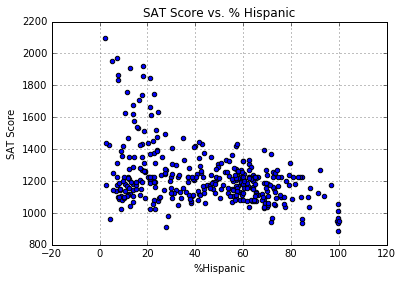

In [65]:
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

ax1.scatter(combined['hispanic_per'], combined["sat_score"])
ax1.set_title("SAT Score vs. % Hispanic") 
ax1.set_xlabel("%Hispanic")
ax1.set_ylabel("SAT Score")
ax1.grid(which='major', axis='both')

plt.show()

<font color = 'red'>CONCLUSION</font>

From 0% to ~ 20% Hispanic there is no correlation to SAT score.  Though there is variation is SAT score for a given value of %Hispanic, from ~ 60% - 100% Hispanic there is a slight negative trend in SAT score as %Hispanic increases.  I am curious about the data between 0 - 20% and 1600 - 2000.  Why are these schools so different from the others?

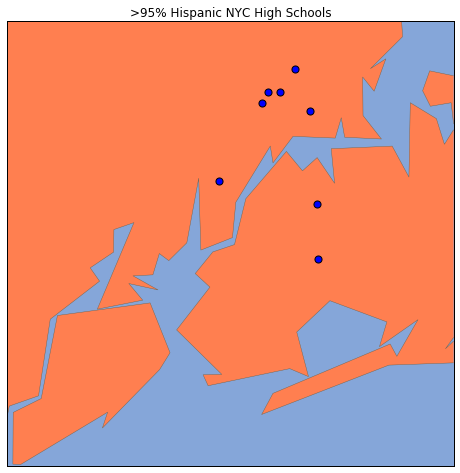

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Demographic,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,grade3,grade4,grade5,grade6,grade7,grade8,grade9,grade10,grade11,grade12,ell_num,ell_percent,sped_num,sped_percent,ctt_num,selfcontained_num,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,bus,subway,primary_address_line_1,city,state_code,zip,website,total_students,campus_name,school_type,overview_paragraph,program_highlights,language_classes,advancedplacement_courses,online_ap_courses,online_language_courses,extracurricular_activities,psal_sports_boys,psal_sports_girls,psal_sports_coed,school_sports,partner_cbo,partner_hospital,partner_highered,partner_cultural,partner_nonprofit,partner_corporate,partner_financial,partner_other,addtl_info1,addtl_info2,start_time,end_time,se_services,ell_programs,school_accessibility_description,number_programs,priority01,priority02,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
44,02M542,MANHATTAN BRIDGES HIGH SCHOOL,66,336.0,378.0,344.0,1058.0,Manhattan Bridges High School,67.000000,102.000000,59.00,Total Cohort,MANHATTAN BRIDGES HIGH SCHOOL,2006,111.000000,77,69.400000000000006%,63,56.8%,81.8%,16,14.4%,20.8%,47,42.3%,61%,14,12.6%,18.2%,17,15.3%,15,13.5%,2,107.187500,4.375000,23.475000,19.187500,26.937500,0.0,MANHATTAN BRIDGES HIGH SCHOOL,20112012,0,83.5,541,,,,,,,,,,,149,168,138,86,393.0,72.6,9.0,1.7,0,5,1,0.2,0,0.0,540,99.8,0,0.0,278.0,51.4,263.0,48.6,94.0,100,83,480.0,37.0,396.0,8.8,8.2,7.6,8.4,7.6,6.6,7.5,8.2,7.2,6.2,6.7,7.5,7.9,7.0,7.3,8.0,02M542,Manhattan Bridges High School,Manhattan,M535,212-757-5274,212-757-5411,9,12,0,12.0,"M104, M11, M31, M34A-SBS, M42, M50, M57","C, E to 50th St",525 West 50Th Street,New York,NY,10019,manhattanbridges.org,552.0,Park West Educational Campus,0,We are a New Visions School founded on the bel...,"College Now, National Academy Foundation, Acad...",Spanish,"Calculus AB, English Language and Composition,...",0,0,"Academic Intervention Services (Extended Day),...","Baseball, Basketball & JV Basketball, Bowling,...","Baseball, Bowling, Handball, Soccer, Tennis, V...","Bowling, Tennis","Running Club, Workout Club",The Young Men and Women Hebrew Association (YM...,"St. Vincent's Hospital, New York-Presbyterian ...","Cornell University, Columbia University, Roche...","El Museo del Barrio, Carnegie Hall, Metropolit...","New Visions for Public Schools, National Acade...","Latin Vision Media, Urban Latino Magazine Inc....","Chase Manhattan Bank, Bank of America","Manhattan District Attorney's Office, New York...","Dress Code Required: white shirt/blouse, black...","Community Service Requirement, Extended Day Pr...",8:00 AM,3:45 PM,This school will provide students with disabil...,ESL; Dual Language: Spanish; Transitional Bili

In [66]:
#next 2 code snippets look into geographical location and hispanic percent

hispanic_95_bool = combined["hispanic_per"]> 95
hispanic_95 = combined[hispanic_95_bool]

# map hispanic_95

fig= plt.figure(figsize = (8,8))

from mpl_toolkits.basemap import Basemap  #map of New York City
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color = "coral", lake_color = "aqua")

longitudes = hispanic_95['lon'].tolist()
latitudes = hispanic_95['lat'].tolist()

m.scatter(longitudes,latitudes, s = 50, zorder = 2, latlon = True, 
          cmap = 'plasma')

plt.title(">95% Hispanic NYC High Schools")
plt.show()
hispanic_95

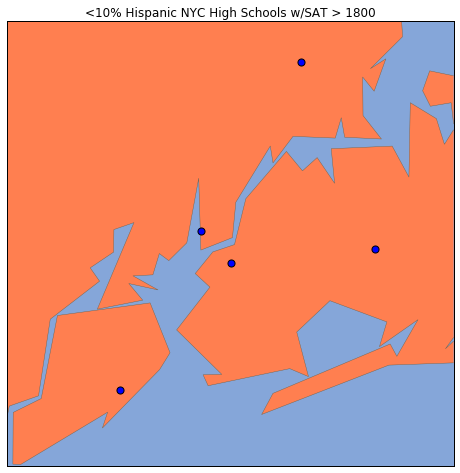

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Demographic,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,grade3,grade4,grade5,grade6,grade7,grade8,grade9,grade10,grade11,grade12,ell_num,ell_percent,sped_num,sped_percent,ctt_num,selfcontained_num,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,bus,subway,primary_address_line_1,city,state_code,zip,website,total_students,campus_name,school_type,overview_paragraph,program_highlights,language_classes,advancedplacement_courses,online_ap_courses,online_language_courses,extracurricular_activities,psal_sports_boys,psal_sports_girls,psal_sports_coed,school_sports,partner_cbo,partner_hospital,partner_highered,partner_cultural,partner_nonprofit,partner_corporate,partner_financial,partner_other,addtl_info1,addtl_info2,start_time,end_time,se_services,ell_programs,school_accessibility_description,number_programs,priority01,priority02,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
37,02M475,STUYVESANT HIGH SCHOOL,832,679.0,735.0,682.0,2096.0,STUYVESANT HS,1510.0,2819.0,2648.0,Total Cohort,STUYVESANT HIGH SCHOOL,2006,787.0,774,98.3%,774,98.3%,100%,770,97.8%,99.5%,4,0.5%,0.5%,0,0%,0%,10,1.3%,3,0.4%,2,876.052632,28.000000,31.115789,24.105263,33.842105,0.0,STUYVESANT HIGH SCHOOL,20112012,0,30.3,3297,,,,,,,,,,,813,827,848,809,0.0,0.0,14.0,0.4,0,0,2377,72.1,40,1.2,80,2.4,780,23.7,1956.0,59.3,1341.0,40.7,93.0,95,33,3039.0,161.0,1062.0,8.4,7.5,7.7,7.7,7.2,5.6,6.1,7.2,7.5,6.2,7.0,7.9,7.7,6.4,6.9,7.6,02M475,Stuyvesant High School,Manhattan,M477,212-312-4800,212-587-3874,9,12,0,12.0,"M20, M22, M5, M9, S1115","1, 2, 3, A, C, E to Chambers St ; R to City Hall",345 Chambers Street,New York,NY,10282,http://stuy.edu,3292.0,0,Specialized School,Our goal is to provide our students with the b...,Mentoring in Intel Science Program through pro...,"Chinese (Mandarin), French, German, Italian, J...","Biology, Calculus AB, Calculus BC, Chemistry, ...",0,0,"Accelerated courses, Student Union, Yearly pub...","Baseball & JV Baseball, Basketball & JV Basket...","Basketball, Bowling, Cross Country, Fencing, G...",Cricket,0,0,"Bellevue Hospital Center, New York-Presbyteria...","New York Law School, New York University (NYU)...",0,"American Red Cross, UNICEF, American Cancer So...",0,"Citicorp, Goldman Sachs",Explorer Program,This is one of New York City's eight (8) Speci...,0,8:00 AM,3:30 PM,This school will provide students with disabil...,ESL,Functionally Accessible,1,Open to New York City residents,0,0,0,0,0,0,0,0,0,"345 Chambers Street\nNew York, NY 10282\n(40.7...",40.717746,-74.014049,02
151,10X445,BRONX HIGH SCHOOL OF SCIENCE,731,632.0,688.0,649.0,1969.0,BRONX HS OF SCIENCE,1190.0,2435.0,2189.0,Total Cohort,BRONX HIGH SCHOOL OF SCIENCE,2006,668.0,657,98.4%,657,98.4%,100%,653,97.8%,

In [67]:
hispanic_10_bool = (combined["hispanic_per"]< 10) & (
    combined["sat_score"] >= 1800)
hispanic_10 = combined[hispanic_10_bool]

# map hispanic_10

fig= plt.figure(figsize = (8,8))

from mpl_toolkits.basemap import Basemap  #map of New York City
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color = "coral", lake_color = "aqua")

longitudes = hispanic_10['lon'].tolist()
latitudes = hispanic_10['lat'].tolist()

m.scatter(longitudes,latitudes, s = 50, zorder = 2, latlon = True, 
          cmap = 'greys')

plt.title("<10% Hispanic NYC High Schools w/SAT > 1800")
plt.show()
hispanic_10

<font color = 'red'>CONCLUSION</font>

I don't see any meaningful location vs. hispanic percent relationship.  Move on to gender differences.

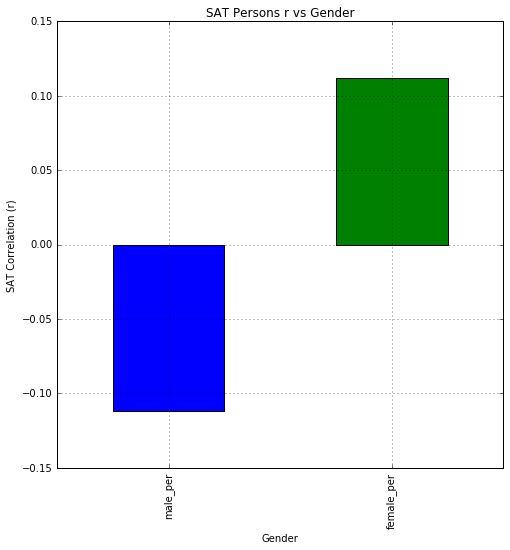

In [69]:
#Any gender differences correlated to SAT score? 
#repeat survey bar chart snippet

gender_sat_data = correlations.loc[[ 
    "male_per",
    "female_per",
]]
gender_sat_data.to_frame()
gender_sat_data.reset_index()

fig = plt.figure(figsize = (8,8))
ax_gend = fig.add_subplot(1,1,1)
ax_gend = gender_sat_data.plot(kind = 'bar', 
                     title = "SAT Persons r vs Gender",
                         grid = True)
ax_gend.set_xlabel("Gender")
ax_gend.set_ylabel("SAT Correlation (r)")
plt.show()

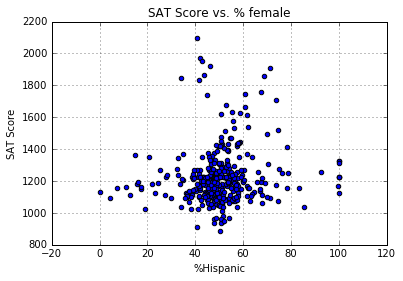

In [71]:
# %female vs. SAT score
fig = plt.figure()
ax_fem = fig.add_subplot(1,1,1)

ax_fem.scatter(combined['female_per'], combined["sat_score"])
ax_fem.set_title("SAT Score vs. % Female") 
ax_fem.set_xlabel("%Femalec")
ax_fem.set_ylabel("SAT Score")
ax_fem.grid(which='major', axis='both')


In [73]:
female_60_bool = (combined["female_per"]> 60) & (
    combined["sat_score"] >= 1700)
female_60 = combined[female_60_bool]
female_60

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Demographic,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,grade3,grade4,grade5,grade6,grade7,grade8,grade9,grade10,grade11,grade12,ell_num,ell_percent,sped_num,sped_percent,ctt_num,selfcontained_num,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,bus,subway,primary_address_line_1,city,state_code,zip,website,total_students,campus_name,school_type,overview_paragraph,program_highlights,language_classes,advancedplacement_courses,online_ap_courses,online_language_courses,extracurricular_activities,psal_sports_boys,psal_sports_girls,psal_sports_coed,school_sports,partner_cbo,partner_hospital,partner_highered,partner_cultural,partner_nonprofit,partner_corporate,partner_financial,partner_other,addtl_info1,addtl_info2,start_time,end_time,se_services,ell_programs,school_accessibility_description,number_programs,priority01,priority02,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.0,604.0,628.0,1856.0,0,129.028846,197.038462,153.45,Total Cohort,BARD HIGH SCHOOL EARLY COLLEGE,2006,139.0,134,96.4%,134,96.4%,100%,0,0%,0%,134,96.4%,100%,0,0%,0%,4,2.9%,1,0.7%,1,214.166667,10.250000,20.975000,17.166667,24.250000,0.0,BARD HIGH SCHOOL EARLY COLLEGE,20112012,0,18.0,617,,,,,,,,,,,184,162,128,143,1.0,0.2,5.0,0.8,0,0,93,15.1,93,15.1,112,18.2,307,49.8,193.0,31.3,424.0,68.7,98.0,81,50,561.0,30.0,283.0,8.8,8.2,8.3,9.1,8.2,7.4,7.5,8.3,8.3,7.3,8.0,8.9,8.5,7.6,8.0,8.7,01M696,Bard High School Early College,Manhattan,M097,212-995-8479,212-777-4702,9,12,0,12.0,"M14A, M14D, M21, M22, M9",0,525 East Houston Street,New York,NY,10002,www.bard.edu/bhsec,560.0,0,0,Bard High School Early College Manhattan (BHSE...,"In the first two years at BHSEC, students unde...","Chinese (Mandarin), Latin, Spanish",0,0,0,"Bard Bulletin online newspaper, Bardvark stude...","Basketball, Soccer, Tennis","Basketball, Soccer, Tennis, Volleyball",Outdoor Track,Co-ed Ultimate Frisbee,"Lower East Side Girls Club, Third Street Music...",0,"Bard College, Bard College at Simon's Rock, Ro...","American Symphony Orchestra, American Museum o...",0,0,0,New York Academy of Sciences,0,Student Summer Orientation,9:00 AM,3:50 PM,This school will provide students with disabil...,ESL,Not Functionally Accessible,1,Open to New York City residents,0,0,0,0,0,0,0,0,0,"525 East Houston Street\nNew York, NY 10002\n(...",40.718962,-73.976066,01
26,02M416,ELEANOR ROOSEVELT HIGH SCHOOL,127,572.0,594.0,592.0,1758.0,Eleanor Roosevelt High School,155.000000,235.000000,169.00,Total Cohort,ELEANOR ROOSEVELT HIGH SCHOOL,2006,127.0,127,100%,126,99.2%,99.2%,110,86.6%,86.6%,16,12.6%,12.6%,1,0.8%,0.8%,0,0%,0,0%,2,138.055556,4.944444,27.433333,23.555556,30.666667,0.0,ELEANOR ROOSEVELT HIGH SCHO

<font color = 'red'>CONCLUSION</font>

I don't see any meaningful gender differences.  Move on to taking AP exams.

In [83]:
#percentage of student body taking an AP class
ombined["ap_per"] = combined["AP Test Takers "] / combined[
    "total_enrollment"] *100
combined["ap_per"].head()

0    30.575556
1     9.898477
2     3.177258
3    35.157724
4    15.809051
Name: ap_per, dtype: float64

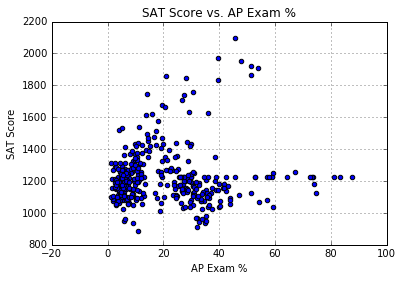

In [84]:
# %Students taking at least 1 AP Exam vs. SAT score
fig = plt.figure()
ax_ap = fig.add_subplot(1,1,1)

ax_ap.scatter(combined['ap_per'], combined["sat_score"])
ax_ap.set_title("SAT Score vs. AP Exam %") 
ax_ap.set_xlabel("AP Exam %")
ax_ap.set_ylabel("SAT Score")
ax_ap.grid(which='major', axis='both')

The gap in SAT scores starting at ~40% is interesting.  Seems certain schools can acheive a significant improvement in SAT scores for their AP students as compared to other schools.  This is probably worth investigating further.